In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:.4f}'.format

import seaborn as sns
import matplotlib.pyplot as plt

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

import time

## Objective: Usng Association Rule Mining

The patterns found by Association Rule Mining represent relationships between observations

More info about associate rule mining: 

https://medium.com/analytics-vidhya/association-rule-mining-7f06401f0601

http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/

### First Exploratory Data Analysis

In [2]:
df=pd.read_csv('./SHR76_19.csv')
#Display columns in list
list(df.columns)

['ID',
 'CNTYFIPS',
 'Ori',
 'State',
 'Agency',
 'Agentype',
 'Source',
 'Solved',
 'Year',
 'StateName',
 'Month',
 'Incident',
 'ActionType',
 'Homicide',
 'Situation',
 'VicAge',
 'VicSex',
 'VicRace',
 'VicEthnic',
 'OffAge',
 'OffSex',
 'OffRace',
 'OffEthnic',
 'Weapon',
 'Relationship',
 'Circumstance',
 'Subcircum',
 'VicCount',
 'OffCount',
 'FileDate',
 'MSA']

In [3]:
print('Number of rows in dataframe',len(df))

Number of rows in dataframe 804751


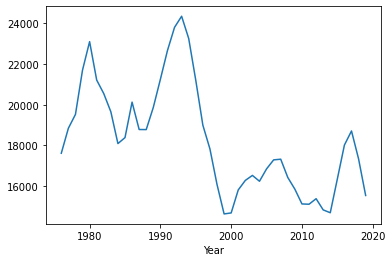

In [4]:
df.groupby(df['Year']).size().plot()

In [5]:
print('Number of rows per state')
df.State.value_counts()

Number of rows per state


California              120462
Texas                    77226
New York                 59516
Florida                  45970
Michigan                 35326
Illinois                 35298
Pennsylvania             30898
Georgia                  26515
North Carolina           25666
Ohio                     25197
Louisiana                24992
Maryland                 21449
Virginia                 19784
Missouri                 19723
Tennessee                19188
New Jersey               17550
Alabama                  16772
Arizona                  15841
South Carolina           15303
Indiana                  14654
Oklahoma                 11184
Washington                9635
Kentucky                  9307
Arkansas                  8860
District of Columbia      8673
Colorado                  8497
Mississippi               8215
Wisconsin                 8050
Massachusetts             7538
Nevada                    7112
Connecticut               5864
New Mexico                5417
Oregon  

In [6]:
print('Distribution of Victims')
df['VicRaceSex']=df['VicRace']+' '+df['VicSex']
df['VicRaceWeapon']=df['VicRace']+' '+df['Weapon']
df['VicRaceSexWeapon']=df['VicRaceSex']+' '+df['Weapon']
df.VicRaceSex.value_counts(normalize=True)

Distribution of Victims


Black Male                                   0.3911
White Male                                   0.3603
White Female                                 0.1337
Black Female                                 0.0815
Asian Male                                   0.0100
Unknown Male                                 0.0073
American Indian or Alaskan Native Male       0.0055
Asian Female                                 0.0044
Unknown Female                               0.0023
American Indian or Alaskan Native Female     0.0020
Unknown Unknown                              0.0015
White Unknown                                0.0001
Native Hawaiian or Pacific Islander Male     0.0001
Black Unknown                                0.0001
Native Hawaiian or Pacific Islander Female   0.0000
Asian Unknown                                0.0000
American Indian or Alaskan Native Unknown    0.0000
Name: VicRaceSex, dtype: float64

In [7]:
df.Solved.value_counts(normalize=True)

Yes   0.7059
No    0.2941
Name: Solved, dtype: float64

In [8]:
df.groupby(['VicRace']).Solved.value_counts(normalize=True)

VicRace                              Solved
American Indian or Alaskan Native    Yes      0.7990
                                     No       0.2010
Asian                                Yes      0.7125
                                     No       0.2875
Black                                Yes      0.6659
                                     No       0.3341
Native Hawaiian or Pacific Islander  Yes      0.8804
                                     No       0.1196
Unknown                              Yes      0.5670
                                     No       0.4330
White                                Yes      0.7456
                                     No       0.2544
Name: Solved, dtype: float64

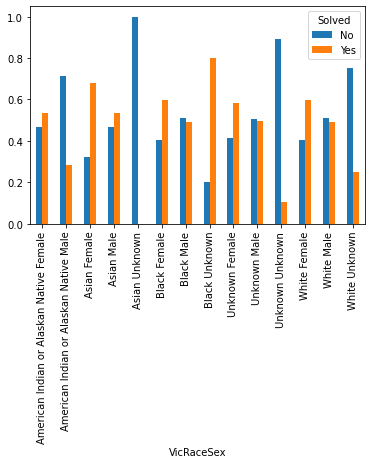

In [9]:
#choose agency of choice
plotSolved=df[df['Agency']=='New York']
#plot the % of solved cases for each demograhpic for the agency of choice
pd.crosstab(plotSolved['VicRaceSex'],plotSolved['Solved'], normalize='index').plot.bar()


In [10]:
#Who are the top 10 agencies with the most cases
dfAgency10 = df[df.groupby("Agency")['Agency'].transform('size') > 8000]
dfAgency10.Agency.value_counts()

New York        45974
Chicago         27873
Los Angeles     27744
Detroit         20938
Houston         16394
Philadelphia    15895
Baltimore       11751
Dallas          11461
New Orleans      9495
Washington       8794
Name: Agency, dtype: int64

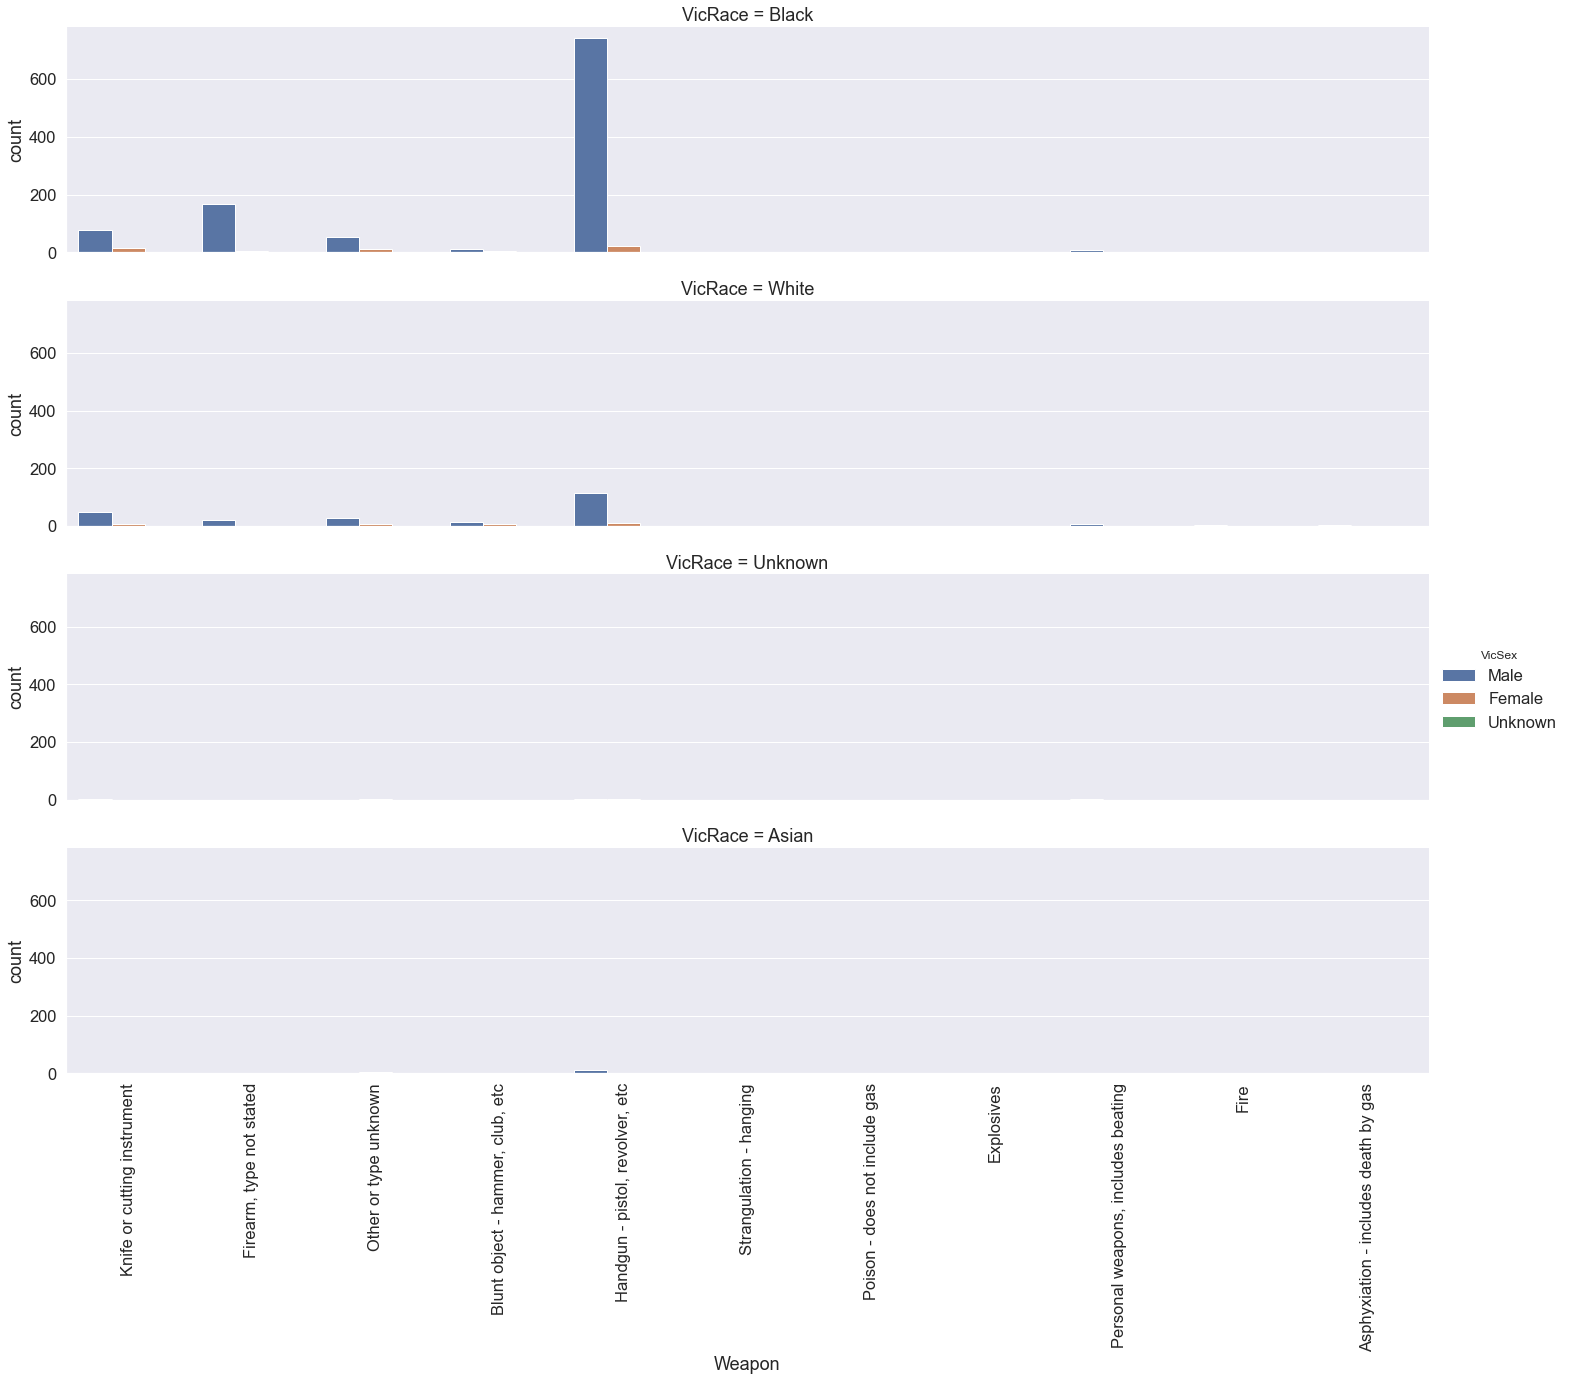

In [11]:
#Plotting the number of unsolved murders per race, gender and weapon type
dfAgency10Unsolved=dfAgency10[dfAgency10['Solved']=='No']
#Specify the agency and years of interest
AgencyOfInterest='New York'
StartingYear=2010
sns.set(font_scale=1.5)
g=sns.catplot(x="Weapon", hue="VicSex", row="VicRace",data=dfAgency10Unsolved[(dfAgency10Unsolved['Agency']==AgencyOfInterest)&(dfAgency10Unsolved['Year']>=StartingYear)], kind="count",orient="h",height=4, aspect=5)
g.set_xticklabels(rotation=90)

## Time for the Associate Rule Mining

Text and code from: http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/

Apriori is a popular algorithm for extracting frequent itemsets with applications in association rule learning. An itemset is considered as "frequent" if it meets a user-specified support threshold. For instance, if the support threshold is set to 0.5 (50%), a frequent itemset is defined as a set of items that occur together in at least 50% of all transactions in the database.

The apriori function expects data in a one-hot encoded pandas DataFrame.

The advantage of working with pandas DataFrames is that we can use its convenient features to filter the results. For instance, let's assume we are only interested in itemsets of length 2 that have a support of at least 80 percent. First, we create the frequent itemsets via apriori and add a new column that stores the length of each itemset.Then, we can select the results that satisfy our desired criteria as follows:

In [12]:
def CustomAssRules(data_array,thres,length):
    #transform the variables: one hot encoding
    te = TransactionEncoder()
    te_ary = te.fit(data_array).transform(data_array)
    dfsubte = pd.DataFrame(te_ary, columns=te.columns_)
    
    start_time = time.time()
    #creating the frequent itemset
    frequent_itemsets = apriori(dfsubte, min_support=thres, use_colnames=True)
    frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
    print("--- %s minutes ---" % ((time.time() - start_time)/60))
    
    #filtering items that return a length greater than the length threshold
    return frequent_itemsets[(frequent_itemsets['length']>=length)].sort_values('support',ascending=False)

Running this function on the entire dataset takes a very long time to run because the dataframe is large I would recommend either increasing the threshold, or by reducing the dataframe size. You can do this by subselecting the state/region or by only looking at solved or solved cases

To save time, and to narrow down the focus, I will demonstrate the CustomAssRules function on a smaller dataset

In [13]:
#only interested in cases since 2010, New York and unsolved
dfcustom=df[(df['Year']>=2010)&(df['State']=='New York')&(df['Solved']=='No')]
print('Number of cases',len(dfcustom))

#Generating a unique Frequent Itemset number based upon the geography (either county/metropolitan area), victims' gender and method of killing.
dfsub=dfcustom[["MSA",'VicRace','VicSex','Weapon']]
dfsub_list = dfsub.to_numpy()

#I am interested in 3 or more similar cases out of all the cases, so the threshold is 3/number of rows in dataframe
custom_thres=3/len(dfcustom)

# I am interested in cases are similiar in county/metro, victim race and weapon used, so I'm interested in 
# a variable that has a length of at least 3
custom_length=3

#Get Frequent Item dataset
frequent_itemsets=CustomAssRules(dfsub_list,custom_thres,custom_length)
frequent_itemsets['cases']=frequent_itemsets['support']*len(dfcustom)
frequent_itemsets['itemlist']=frequent_itemsets['itemsets'].apply(lambda x:', '.join(map(str,x)))
frequent_itemsets.head(10)

Number of cases 2416
--- 0.0009916146596272786 minutes ---


,support,itemsets,length,cases,itemlist
234,0.4934,"(New York-New Jersey-Long Island, NY-NJ, Male, Black)",3,1192.0000,"New York-New Jersey-Long Island, NY-NJ, Male, Black"
225,0.4863,"(Handgun - pistol, revolver, etc, Male, Black)",3,1175.0000,"Handgun - pistol, revolver, etc, Male, Black"
305,0.4011,"(New York-New Jersey-Long Island, NY-NJ, Handgun - pistol, revolver, etc, Male)",3,969.0000,"New York-New Jersey-Long Island, NY-NJ, Handgun - pistol, revolver, etc, Male"
226,0.3448,"(New York-New Jersey-Long Island, NY-NJ, Handgun - pistol, revolver, etc, Black)",3,833.0000,"New York-New Jersey-Long Island, NY-NJ, Handgun - pistol, revolver, etc, Black"
381,0.3349,"(New York-New Jersey-Long Island, NY-NJ, Handgun - pistol, revolver, etc, Male, Black)",4,809.0000,"New York-New Jersey-Long Island, NY-NJ, Handgun - pistol, revolver, etc, Male, Black"
331,0.1395,"(New York-New Jersey-Long Island, NY-NJ, Male, White)",3,337.0000,"New York-New Jersey-Long Island, NY-NJ, Male, White"
220,0.1308,"(Male, Black, Firearm, type not stated)",3,316.0000,"Male, Black, Firearm, type not stated"
204,0.1204,"(Male, Buffalo-Niagara Falls, NY, Black)",3,291.0000,"Male, Buffalo-Niagara Falls, NY, Black"
257,0.1175,"(Handgun - pistol, revolver, etc, Male, Buffalo-Niagara Falls, NY)",3,284.0000,"Handgun - pistol, revolver, etc, Male, Buffalo-Niagara Falls, NY"
202,0.1151,"(Handgun - pistol, revolver, etc, Buffalo-Niagara Falls, NY, Black)",3,278.0000,"Handgun - pistol, revolver, etc, Buffalo-Niagara Falls, NY, Black"


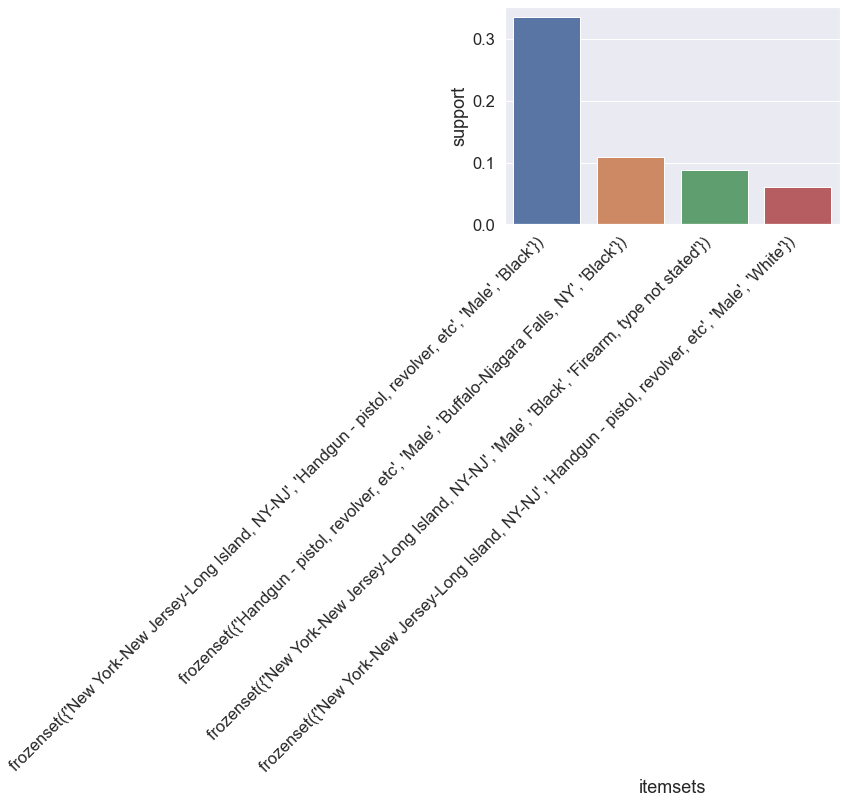

In [14]:
#plot top clusters with min support of interest
ax=sns.barplot(x="itemsets", y="support", data=frequent_itemsets[(frequent_itemsets['support']>=0.05)&(frequent_itemsets['length']>=4)].sort_values("support", ascending=False))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

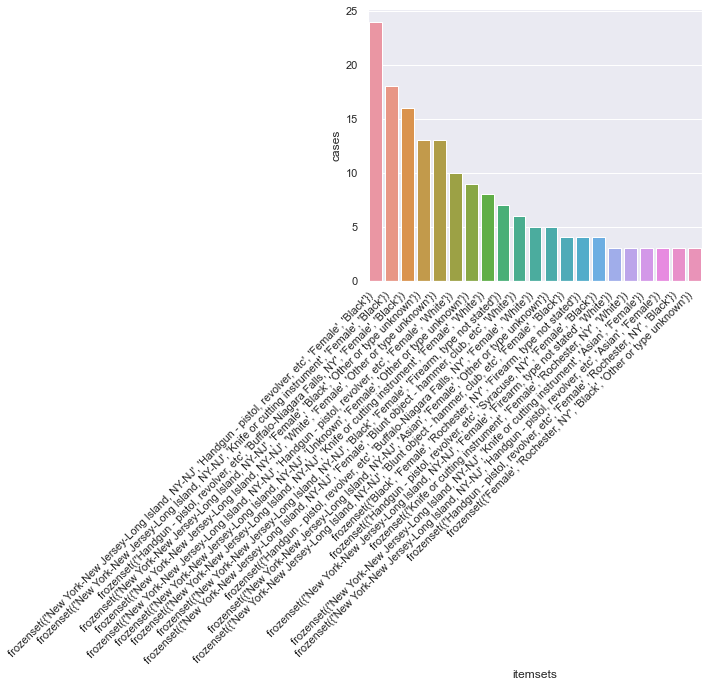

In [15]:
sns.set(rc={"figure.figsize":(6, 5)}) #width=6, height=5

#plot the most frequently occuring of cases with female victims
ax=sns.barplot(x="itemsets", y="cases", data=frequent_itemsets[(frequent_itemsets['cases']>=3)&\
                                                               (frequent_itemsets['itemlist'].str.contains('Female')\
                                                               )&(frequent_itemsets['length']>=4)].sort_values("support", ascending=False))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

In [16]:
#If you are interested in specific variables
frequent_itemsets[ frequent_itemsets['itemsets'] == {'Black', 'Male'} ]

,support,itemsets,length,cases,itemlist
